# Estimating latent variables

## Imports

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import pandas as pd

## Defining the first problem: unknown, biased coins

**We are going to study the following problem:** 

Consider a set of $p$ independent, biased coins, each characterized by the $\theta^{(k)}, \; 1\leq k \leq p$ of giving heads. During a sequence of $N$ sets, we are going to pick one coin at random, with equal probability between coins and no memory, and toss the selected coin $n$ times. The observed number of heads will be noted $X_i, \; 1 \leq i \leq N$. Our goal will be to estimate the underlying (latent) variables $\theta^{(1)}, ..., \theta^{(p)}$, without knowing which coin has been tossed at a given set.

%%latex

\begin{align}
    \forall i &\in \llbracket 1,N \rrbracket, \\    
    X_i|\theta &\sim \mathcal{B}(n, \theta), \\
    \theta &\sim \text{Discrete}(\theta^{(1)}, ..., \theta^{(p)}).
\end{align}

To have solvability, we assume $p\in\mathbb{N}$ known. For simplicity, we will assume $\theta^{(1)} \leq ... \leq \theta^{(p)}$.

In [10]:
#generating data
def simulate(N, n, theta, seed=13):
    rand.seed(seed)
    tosses =  [f'x_{i}' for i in range(n)]
    z = rand.randint(low=0, high=len(theta), size=(N,))
    df = pd.DataFrame(columns=['z']+tosses, index=np.arange(N))
    df['z'] = z
    x = rand.uniform(size=(N,n))
    data = (x <= theta[z][:, None]).astype(int) #this is a useful numpy trick !!
    df[tosses] = data
    return df

### Solving two coin problem with method of moments

For this first problem, we are going to consider a simple case of two coins, each with a probability of giving heads $\theta^{(1)}, \; \theta^{(2)} \; \text{s.t.} \; \theta^{(1)}\leq \theta^{(2)}$. The method of moments boils down to computing an expression for the variable in question (here: $X$)'s moments as a function of the unknown parameters, in order to create a system of equations. Upon solving this system of equations, we should get an expression for the unknown parameters ($\theta^{(1)}, \; \theta^{(2)}$) as a function of the moments. The highest order moment that we need to compute, has an order which is the same as the number of parameters.

For this first example, we will consider the simplest version of the problem; that of two unknown, biased coins.

In [11]:
theta = np.array([0.25, 0.85]) #chance of getting heads: 0 (tails: 1)

N = 100 #number of sets
n = 20 #number of tosses


df = simulate(N, n, theta)
df

,z,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
0,0,0,0,1,1,1,1,0,0,1,...,0,1,0,0,1,1,0,0,0,0
1,0,0,1,0,0,1,0,1,1,0,...,0,0,1,0,1,1,0,0,0,1
2,0,0,0,1,1,0,1,1,0,0,...,0,0,0,1,0,1,0,1,1,1
3,0,0,1,1,1,0,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0
4,0,0,0,1,1,0,0,0,0,0,...,1,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,1,1,1,0,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
96,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
97,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
98,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Let us observe the mean of $X|\theta$ on the sample of size $N\times n$ (for $N$ or $n$ small, this method shouldn't be too accurate...):

Text(0.5, 1.0, 'Observed v. theoretical probability of heads')

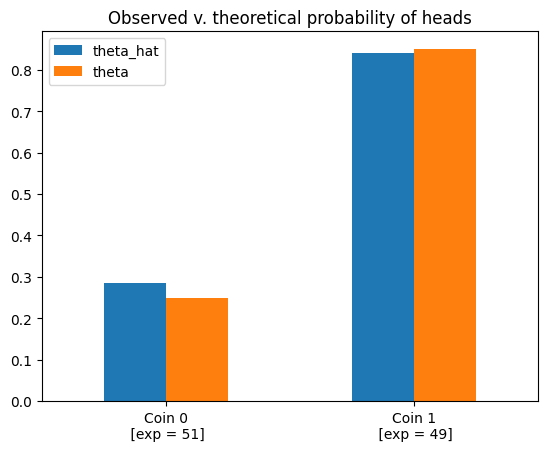

In [12]:
results = df.groupby('z').mean().mean(axis=1)
results.name = 'theta_hat'
results = pd.DataFrame(results)
results['theta'] = [theta[z] for z in results.index]

tmp = df.z.sum() #nb of times coin 1 was selected
exposure = [N-tmp, tmp]

results.plot(kind='bar')
plt.xticks(np.arange(len(theta)), [f'Coin {i}\n [exp = {exposure[i]:d}]' for i in range(len(theta))], rotation=0)
plt.xlabel("")
plt.title("Observed v. theoretical probability of heads")


We observe that the mean of $X|\theta$ struggles to estimate the correct probability of heads for the first coin (Coin 0).

### The mathematics

In [13]:
#we drop the z axis
z = df.z.copy()
df.drop(columns='z', inplace=True)
df

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
0,0,0,1,1,1,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0
1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0,0,0,1
2,0,0,1,1,0,1,1,0,0,0,0,0,0,1,0,1,0,1,1,1
3,0,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0
4,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
96,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0
97,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
98,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Now, we do not know which coin was selected for each set of tosses. However, we suppose that we still know that there were only two coins to pick from. Let us use the **method of moments** to estimate the probability of heads for each of the two "latent coins".

In [14]:
%%latex

Because $X|\theta$ is a Bernoulli variable following the distribution $\mathcal{B}(n, \theta)$, we know that
\begin{equation}
    \forall k, \; \mathbb{E}(X|\theta = \theta^{(k)}) = n\times \theta^{(k)}
\end{equation}
This gives us an expression for the expectancy of $X$, which is what we are looking for
\begin{equation}
    \mathbb{E}(X) = \mathbb{E}(\mathbb{E}(X|\theta)) = \sum_{k\in\{1,2\}} \mathbb{E}(X|\theta=\theta^{(k)})\mathbb{P}(\theta=\theta^{(k)}) = \frac{n}{2}(\theta^{(1)}+ \theta^{(2)})
\end{equation}
This gives us the first equation for our system.

We also want to have a second order moment, to complete our system. We will use the second factorial moment, but in theory, any moment that cannot be expressed as a linear function of the first order moment, should be suitable for generating a solvable system of euqations.
Because the linearity of the expectancy operator allows us to write $\mathbb{E}(X(X-1)) = \mathbb{E}(X^2) - \mathbb{E}(X)$, we are going to focus on the second order moment first, as we already have an expression for $\mathbb{E}(X)$.


\begin{equation}
    \mathbb{E}(X^2) = \mathbb{E}(\mathbb{E}(X^2|\theta)) = \sum_{k\in\{1,2\}} \mathbb{E}(X^2|\theta=\theta^{(k)})\mathbb{P}(\theta=\theta^{(k)})
\end{equation}


<IPython.core.display.Latex object>

In [15]:
%%latex

However,
\begin{equation} 
    \mathbb{E}(X^2|\theta=\theta^{(k)}) = \operatorname{Var}(X|\theta=\theta^{(k)}) + \mathbb{E}(X|\theta=\theta^{(k)})^2 = n\theta^{(k)}(1-\theta^{(k)}) + n^2(\theta^{(k)})^2 = (n^2-n)(\theta^{(k)})^2 + n\theta^{(k)}
\end{equation}

Which gives,

\begin{equation}
    \mathbb{E}(X(X-1)) = \sum_{k\in\{1,2\}} (n^2-n)(\theta^{(k)})^2 \mathbb{P}(\theta=\theta^{(k)}) + \sum_{k\in\{1,2\}} n\theta^{(k)} \mathbb{P}(\theta=\theta^{(k)}) - \mathbb{E}(X) = \sum_{k\in\{1,2\}} (n^2-n)(\theta^{(k)})^2 \mathbb{P}(\theta=\theta^{(k)}) = \frac{n^2-n}{2}\left((\theta^{(1)})^2+(\theta^{(2)})^2\right)
\end{equation}
(This will give us our second equation for the system)

Finally, noting $\mu$ the first order moment and $\nu$ the second factorial moment, we get the system of euqations

\begin{equation}
    \begin{cases}
        \mu &= \frac{n}{2}(\theta^{(1)}+ \theta^{(2)}) \\
        \nu &= \frac{n^2-n}{2}\left((\theta^{(1)})^2+(\theta^{(2)})^2\right)
    \end{cases}
\end{equation}

<IPython.core.display.Latex object>

In [16]:
%%latex

Let us try to solve this system, supposing that $0 \lt n \lt 1$:

\begin{equation}
    \begin{cases}
        \mu &= \frac{n}{2}(\theta^{(1)}+ \theta^{(2)}) \\
        \nu &= \frac{n^2-n}{2}\left((\theta^{(1)})^2+(\theta^{(2)})^2\right)
    \end{cases}
    \iff
    \begin{cases}
        \theta^{(2)} &= \frac{2}{n}\mu - \theta^{(1)} \\
        \frac{2}{n^2-n} \nu &= (\theta^{(1)})^2+ (\frac{2}{n}\mu - \theta^{(1)})^2 = 2 (\theta^{(1)})^2 - \frac{4}{n}\mu\theta^{(1)} + (\frac{2}{n}\mu)^2  
    \end{cases}
    \iff
    \begin{cases}
        \theta^{(2)} &= \frac{2}{n}\mu - \theta^{(1)} \\
        (\theta^{(1)})^2 &- \frac{2}{n}\mu\theta^{(1)}+\frac{2}{n^2}\mu^2-\frac{1}{n^2-n}\nu = 0        
    \end{cases}

\end{equation}

We can obtain $\theta^{(1)}$ by use of the quadratic formula:

\begin{equation}
    \begin{cases}
        \theta^{(1)} &= \frac{\frac{2}{n}\mu\pm\sqrt{\frac{4}{n^2}\mu^2-4\times(\frac{2}{n^2}\mu^2-\frac{1}{n^2-n}\nu)}}{2} = \frac{1}{n}\mu \pm \frac{1}{2}\sqrt{-4\frac{1}{n^2}\mu^2+4\frac{1}{n^2-n}\nu} = \frac{1}{n}\mu \pm \sqrt{\frac{1}{n^2-n}\nu-\frac{1}{n^2}\mu^2} \\
        \theta^{(2)} &= \frac{2}{n}\mu - \theta^{(1)}
    \end{cases}
\end{equation}


<IPython.core.display.Latex object>

In [17]:
def theta_est(mu, nu, n):
    delta = 1/(n**2-n)*nu-mu**2/n**2
    if delta<0:
        raise ValueError(f'Delta = {delta:.4f} not possible to compute theta')
    theta1 = 1/n*mu + np.sqrt(delta)
    if theta1 < 0 or theta1 > 1:
        theta1 = 1/n*mu - np.sqrt(delta)
    theta2 = 2/n*mu - theta1
    return min(theta1, theta2), max(theta1, theta2) #to satisfy our assumption


In [18]:
#we can compute the observed first moment and second factorial moment quite easily

X = df.sum(axis = 1) #remember: we are counting the number of heads
print(X)

mu = X.mean()
nu = (X*(X-1)).mean()

print("")
print(f'mu = {mu:.4f}')
print(f'nu = {nu:.4f}')

0      8
1      8
2      9
3      8
4      7
      ..
95    18
96     5
97    19
98    19
99    14
Length: 100, dtype: int64

mu = 11.1400
nu = 146.9400


In [19]:
theta_mom = theta_est(mu, nu, n)
theta_mom

(np.float64(0.2805308145085319), np.float64(0.8334691854914682))

Text(0.5, 1.0, 'Observed v. theoretical probability of heads')

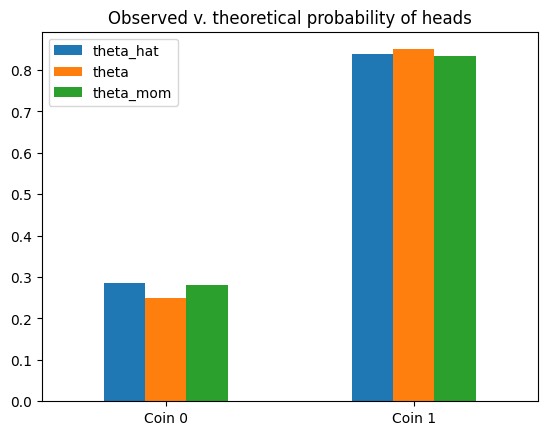

In [20]:
results['theta_mom'] = theta_mom

results.plot(kind='bar')
plt.xticks(np.arange(len(theta)), [f'Coin {i}' for i in range(len(theta))], rotation=0)
plt.xlabel("")
plt.title("Observed v. theoretical probability of heads")

In [21]:
#we will try a more computation-heavy approach to see the convergency rate of the method of moments

from itertools import product

N_tilde = 10000
n_tilde = 200
theta_tilde = np.array([0.10, 0.90])
df_long = simulate(N_tilde, n_tilde , theta_tilde)
theta_long = np.array([theta_tilde for _ in range(N_tilde)])

In [22]:
df_long

,z,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_190,x_191,x_192,x_193,x_194,x_195,x_196,x_197,x_198,x_199
0,0,0,1,0,1,0,1,1,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,1
2,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9997,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9998,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,0,1


In [23]:
theta_long = np.array(N_tilde*list(theta_tilde))
theta_long = theta_long.reshape((N_tilde, len(theta_tilde)))
theta_long.shape #seems OK

(10000, 2)

In [24]:
X_long = df_long.drop(columns='z').sum(axis=1)
mu_long = X_long.expanding().mean()
mu_long

0       16.000000
1       21.000000
2       20.333333
3       21.000000
4       20.000000
          ...    
9995    98.712185
9996    98.703911
9997    98.696239
9998    98.704370
9999    98.712600
Length: 10000, dtype: float64

In [25]:
nu_long = (X_long*(X_long -1)).expanding().mean()
nu_long

0         240.000000
1         445.000000
2         410.666667
3         434.500000
4         395.600000
            ...     
9995    16060.335334
9996    16058.752826
9997    16057.192839
9998    16058.809281
9999    16060.461400
Length: 10000, dtype: float64

In [26]:
theta_mom_long = np.zeros((N_tilde, 2))
for i, (mu, nu) in enumerate(zip(mu_long, nu_long)):
    try:
        theta_mom_long[i, :] = theta_est(mu, nu, n_tilde)
    except Exception:
        pass

In [27]:
theta_mom_long

array([[0.        , 0.        ],
       [0.09251383, 0.11748617],
       [0.        , 0.        ],
       ...,
       [0.093577  , 0.89338539],
       [0.09361705, 0.89342666],
       [0.09365708, 0.89346892]])

In [28]:
df_long     

,z,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_190,x_191,x_192,x_193,x_194,x_195,x_196,x_197,x_198,x_199
0,0,0,1,0,1,0,1,1,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,1
2,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9997,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9998,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,0,1


In [29]:
df_new_long = df_long.copy()

df_new_long['Coin 1'] = df_long.drop(columns="z").sum(axis=1)*(df_long.z==0)
df_new_long['Coin 2'] = df_long.drop(columns='z').sum(axis=1)*(df_long.z==1)

to_remove = df_new_long.columns.to_list()
to_remove.remove('z')
to_remove.remove('Coin 1')
to_remove.remove('Coin 2')

df_new_long = df_new_long.drop(columns=to_remove)
df_new_long

,z,Coin 1,Coin 2
0,0,16,0
1,0,26,0
2,0,19,0
3,0,23,0
4,0,16,0
...,...,...,...
9995,0,17,0
9996,0,16,0
9997,0,22,0
9998,1,0,180


In [30]:
#fill in occurrences of each coin
df_new_long['Occurences Coin 1'] = (df_new_long.z==0).cumsum()
df_new_long['Occurences Coin 2'] = (df_new_long.z==1).cumsum()
df_new_long

,z,Coin 1,Coin 2,Occurences Coin 1,Occurences Coin 2
0,0,16,0,1,0
1,0,26,0,2,0
2,0,19,0,3,0
3,0,23,0,4,0
4,0,16,0,5,0
...,...,...,...,...,...
9995,0,17,0,5074,4922
9996,0,16,0,5075,4922
9997,0,22,0,5076,4922
9998,1,0,180,5076,4923


In [31]:
#compute the evolution of theta1 & 2
df_new_long["Theta 1"] = df_new_long["Coin 1"].cumsum()/df_new_long["Occurences Coin 1"]/n_tilde
df_new_long["Theta 2"] = df_new_long["Coin 2"].cumsum()/df_new_long["Occurences Coin 2"]/n_tilde
df_new_long

,z,Coin 1,Coin 2,Occurences Coin 1,Occurences Coin 2,Theta 1,Theta 2
0,0,16,0,1,0,0.080000,NaN
1,0,26,0,2,0,0.105000,NaN
2,0,19,0,3,0,0.101667,NaN
3,0,23,0,4,0,0.105000,NaN
4,0,16,0,5,0,0.100000,NaN
...,...,...,...,...,...,...,...
9995,0,17,0,5074,4922,0.099707,0.899577
9996,0,16,0,5075,4922,0.099703,0.899577
9997,0,22,0,5076,4922,0.099705,0.899577
9998,1,0,180,5076,4923,0.099705,0.899577


In [32]:
df_new_long[["Theta 1", "Theta 2"]] = df_new_long[["Theta 1", "Theta 2"]].fillna(0)
df_new_long

,z,Coin 1,Coin 2,Occurences Coin 1,Occurences Coin 2,Theta 1,Theta 2
0,0,16,0,1,0,0.080000,0.000000
1,0,26,0,2,0,0.105000,0.000000
2,0,19,0,3,0,0.101667,0.000000
3,0,23,0,4,0,0.105000,0.000000
4,0,16,0,5,0,0.100000,0.000000
...,...,...,...,...,...,...,...
9995,0,17,0,5074,4922,0.099707,0.899577
9996,0,16,0,5075,4922,0.099703,0.899577
9997,0,22,0,5076,4922,0.099705,0.899577
9998,1,0,180,5076,4923,0.099705,0.899577


In [33]:
#save to numpy
theta_hat_long = df_new_long[["Theta 1", "Theta 2"]].to_numpy()
theta_hat_long.shape

(10000, 2)

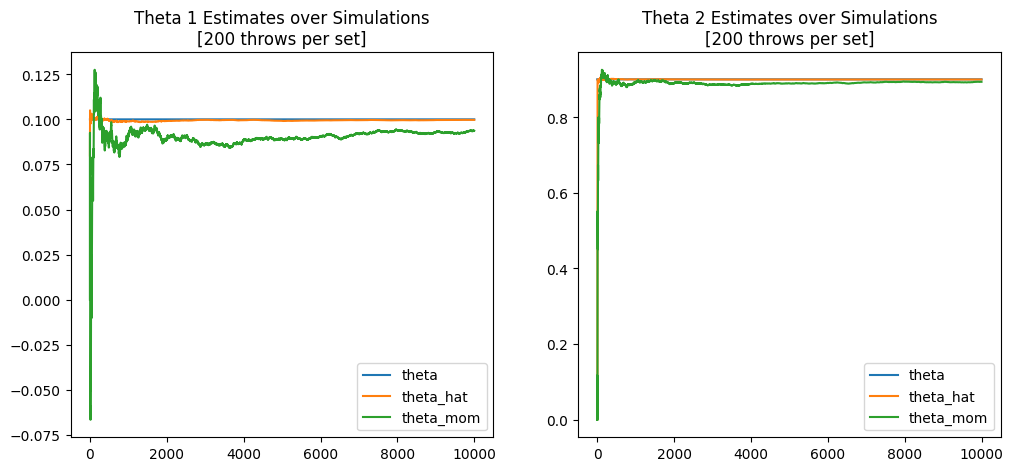

In [34]:
fig,ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_title(f'Theta 1 Estimates over Simulations\n[{n_tilde:d} throws per set]')
ax[1].set_title(f'Theta 2 Estimates over Simulations\n[{n_tilde:d} throws per set]')
for i, (name, data) in product([0,1], zip(['theta', 'theta_hat', 'theta_mom'], [theta_long, theta_hat_long, theta_mom_long])):
    ax[i].plot(data[:,i], label=name)
ax[0].legend()
ax[1].legend()

## Defining the second problem: number of ski-goers, knowing days of snow

**We are going to study the following problem:** 
Consider a set of $M\in\mathbb{N}$ independent skiing seasons, each characterized by a number snow days $N_i, \; 1\leq i \leq M$ and a number of skiers $Z_i$. We know that each winter can follow one out of two regimes: "warm" or "cold", with respective propability $p$ and $q=1-p$. The number of skiers per season is a linear function of the number of days of snow for the season, with parameters $\alpha, \beta$, plus some Gaussian noise $\mathcal{N}(0, \sigma), \; \sigma \gt 0$. The number of snow days follows a Poisson distribution, with mean $\lambda^{(k)}, \; k \in \{1,2\}$, where $k$ describes the seasons regime. 

We are the owners of a skiing station in the French Alps, and we want to determine the parameters of the linear function: $\alpha$ and $\beta$, in order to get an idea of the number of skiiers next season, given the regime or number of snow days.

%%latex
\begin{align}
    \forall i &\in \{1, \dots, M\}, \\
    \lambda_i &\sim p \, \delta_{\lambda^{(1)}} + q \, \delta_{\lambda^{(2)}} \\
    &\quad \text{with } p + q = 1, \\
    N_i \mid \lambda_i &\sim \text{Poisson}(\lambda_i), \\
    Z_i \mid N_i &= \alpha + \beta N_i + \varepsilon_i, \\
    \varepsilon_i &\sim \mathcal{N}(0, \sigma^2).
\end{align}


In [49]:
def simulate_skiers(M, p, lambdas, alpha, beta, sigma, seed=163):
    rand.seed(seed)
    regimes = rand.uniform(size=M)
    regimes = (regimes < p).astype(int) #p chance of regime 2(1), q=1-p chance of regime 1(0)
    nb_reg_2 = np.sum(regimes) #number of times regime 2 appears
    snow_days = np.zeros(shape=(M,))
    mask = regimes.astype(bool).flatten()
    snow_days[mask] = rand.poisson(lam=lambdas[1], size=nb_reg_2)
    snow_days[~mask] = rand.poisson(lam=lambdas[0], size=M-nb_reg_2)
    noise = rand.normal(loc=0, scale=sigma, size=M)
    ski_goers = alpha + beta * snow_days + noise
    df = pd.DataFrame({'regime': regimes, 'snow_days': snow_days, 'ski_goers': ski_goers, 'noise': noise})    
    return df

In [60]:
#first test

lambdas = [300, 450]
M = 50 #50 years of data
p = 0.25 #probability of regime 2
alpha = 100
beta = 1.3
sigma = 10 
df_skiers = simulate_skiers(M, p, lambdas, alpha, beta, sigma)

<Axes: >

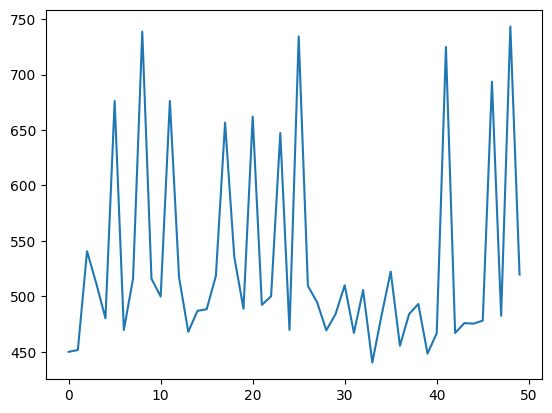

In [61]:
df_skiers['ski_goers'].plot(kind='line')

### The mathematics

%%latex

We can compute the first order moment like this:

\begin{align}
    \mathbb{E}(Z) &= \sum_{i\in\{1,2\}}\sum_{k\in\mathbb{N}}\mathbb{E}(Z|N=k;\lambda=\lambda^{(i)})\mathbb{P}(N=k;\lambda=\lambda^{(i)}) \\
    &= (1-p)\times \sum_{k\in\mathbb{N}}\mathbb{E}_{\lambda^{(1)}}(Z|N=k)\mathbb{P}_{\lambda^{(1)}}(N=k) + p\times \sum_{k\in\mathbb{N}}\mathbb{E}_{\lambda^{(2)}}(Z|N=k)\mathbb{P}_{\lambda^{(2)}}(N=k) \\
    &= (1-p)\times \sum_{k\in\mathbb{N}}(\alpha + \beta \lambda^{(1)})\mathbb{P}_{\lambda^{(1)}}(N=k) + p \times \sum_{k\in\mathbb{N}}(\alpha + \beta \lambda^{(2)})\mathbb{P}_{\lambda^{(2)}}(N=k) \\
    &= (1-p)\times(\alpha + \beta \lambda^{(1)}) + p \times (\alpha + \beta \lambda^{(2)}) \;\text{because the sums equal }1 \\
    &= \alpha + \left((1-p)\lambda^{(1)} + p\lambda^{(2)} \right)\beta
     
\end{align}

%%latex

We can compute the second order moment like this:

